In [1]:
import sys
sys.path.append("../../digitech_classify")

import pandas as pd
from digitech_classify.features import get_spacy_models, batch_lemmatize
from digitech_classify.config import PROCESSED_DATA_DIR, DATA_DIR, RAW_DATA_DIR




In [2]:
df = pd.read_csv(PROCESSED_DATA_DIR / 'company_tagged_all-MiniLM-L6-v2.csv')
keyword_sector_mapping = pd.read_excel(DATA_DIR / 'keywords_combined_digital/Keywords_Combined.xlsx', sheet_name='Sheet1')
glass_AI = pd.read_excel(PROCESSED_DATA_DIR / 'glassAI_crunchbase_overlap.xlsx')


In [3]:
print(df.shape)

(107335, 5)


In [4]:
keyword_sector_mapping = keyword_sector_mapping.drop(columns=['Cluster', 'Subcluster'])
keyword_sector_mapping = keyword_sector_mapping[keyword_sector_mapping['yes/no'] == 'yes']
keyword_sector_mapping = keyword_sector_mapping.drop(columns=['yes/no'])
keyword_sector_mapping['Keyword'] = keyword_sector_mapping['Keyword'].str.lower().str.strip()

In [5]:
model = get_spacy_models()

keyword_sector_mapping['Keyword_lemmatized'] = batch_lemmatize(keyword_sector_mapping['Keyword'].fillna(''))


Processing texts: 100%|██████████| 2057/2057 [00:00<00:00, 10120.44it/s]


In [6]:

df_filtered_companies = df[df['similarity'] >= 0.6]


df_filtered_companies = df_filtered_companies.merge(
    keyword_sector_mapping,
    left_on='keyword',
    right_on='Keyword_lemmatized',
    how='left'
)



In [7]:
df_unique_companies_by_sector = df_filtered_companies.groupby(['Sector', 'organisation_name'], as_index=False).first()
df_filtered_companies_sector_group = df_unique_companies_by_sector.groupby('Sector').size().reset_index(name='count') 
print(df_unique_companies_by_sector.shape)

(68040, 8)


In [8]:
df_unique_companies_by_sector = df_unique_companies_by_sector.drop(columns=['keyword', 'Keyword_lemmatized'])

In [ ]:
sector_list = df_unique_companies_by_sector['Sector'].unique().tolist()
df_unique_companies_by_sector['Sector'] = df_unique_companies_by_sector['Sector'].str.lower().str.strip()



['Artificial Intelligence', 'Blockchain', 'Cloud-edge-IoT', 'Cybersecurity', 'Data analytics', 'Photonics', 'Quantum technologies', 'Robotics', 'advanced digital communications and connectivity', 'high performance computing', 'next generation internet and extended reality', 'photonics']


In [11]:
sector_dfs = {sector: df_unique_companies_by_sector[df_unique_companies_by_sector['Sector'] == sector] for sector in sector_list}

In [12]:
for sector, sector_df in sector_dfs.items():
    print(f"Sector: {sector}")

Sector: Artificial Intelligence
Sector: Blockchain
Sector: Cloud-edge-IoT
Sector: Cybersecurity
Sector: Data analytics
Sector: Photonics
Sector: Quantum technologies
Sector: Robotics
Sector: advanced digital communications and connectivity
Sector: high performance computing
Sector: next generation internet and extended reality
Sector: photonics


In [ ]:
df_unique_companies_by_sector.to_excel(DATA_DIR / 'sector_companies_enriched_agg.xlsx', index=False)


In [13]:
missing_companies = df_unique_companies_by_sector[~df_unique_companies_by_sector['org_ID'].isin(glass_AI['org_ID'])]

glass_AI_enriched = pd.concat([glass_AI, missing_companies], ignore_index=True)

In [14]:
missing_companies.shape 

(62745, 6)

In [16]:
glass_AI_enriched['sector'] = glass_AI_enriched['Sector'].combine_first(glass_AI_enriched['digital_sector'])
glass_AI_enriched = glass_AI_enriched.drop(columns=['Sector', 'digital_sector', 'id_organization', 'keywords_mentioned', 'crawling_keywords_mentioned'])

In [17]:
glass_AI_enriched['sector'] = glass_AI_enriched['sector'].str.lower().str.strip()
print(glass_AI_enriched['sector'].unique())



['cloud-edge-iot' 'high performance computing' 'data analytics'
 'advanced digital communications and connectivity' 'cybersecurity'
 'artificial intelligence' 'blockchain' 'quantum technologies' 'robotics'
 'photonics' 'next generation internet and extended reality' nan]


In [ ]:
print(glass_AI_enriched['sector'].unique())
sector_mapping = {
    'Cloud to Edge to IoT': 'cloud-edge-iot',
    'Data Analytics Technologies': 'data analytics',
    'Artificial Intelligence': 'artificial intelligence',
    'Blockchain Technologies': 'blockchain',
    'Photonics Technologies': 'photonics',
    'Quantum Technologies': 'quantum technologies',
    'Robotics Technologies': 'robotics',
    'Advanced Digital Communications and Connectivity': 'advanced digital communications and connectivity',
    'High Performance Computing': 'high performance computing',
    'Next Generation Internet and Extended Reality': 'next generation internet and extended reality',
    'Microelectronics, High Frequency Chips and Semiconductors': 'microelectronics, high frequency chips and semiconductors'
    
}

glass_AI_enriched['sector'] = glass_AI_enriched['sector'].combine_first(
    glass_AI_enriched['digital_sector_glassAI'].map(sector_mapping)
)
print(glass_AI_enriched['sector'].unique())
print(glass_AI_enriched['digital_sector_glassAI'].unique())

['cloud-edge-iot' 'high performance computing' 'data analytics'
 'advanced digital communications and connectivity' 'cybersecurity'
 'artificial intelligence' 'blockchain' 'quantum technologies' 'robotics'
 'photonics' 'next generation internet and extended reality' nan]
['cloud-edge-iot' 'high performance computing' 'data analytics'
 'advanced digital communications and connectivity' 'cybersecurity'
 'artificial intelligence' 'blockchain' 'quantum technologies' 'robotics'
 'photonics' 'next generation internet and extended reality' nan
 'microelectronics, high frequency chips and semiconductors']
['Cloud to Edge to IoT' 'Data Analytics Technologies'
 'Advanced Digital Communications and Connectivity' 'Cybersecurity'
 'Artificial Intelligence' 'Advanced and High Performance Computing'
 'Blockchain, Distributed Ledger and Digital Identity Technologies'
 'Microelectronics, High Frequency Chips and Semiconductors'
 'Next Generation Internet and Extended Reality' 'Quantum'
 'Photonics Tech

In [21]:
glass_AI_enriched['sector'] = glass_AI_enriched['sector'].fillna(glass_AI_enriched['digital_sector_glassAI'])
glass_AI_enriched['sector'] = glass_AI_enriched['sector'].str.lower().str.strip()

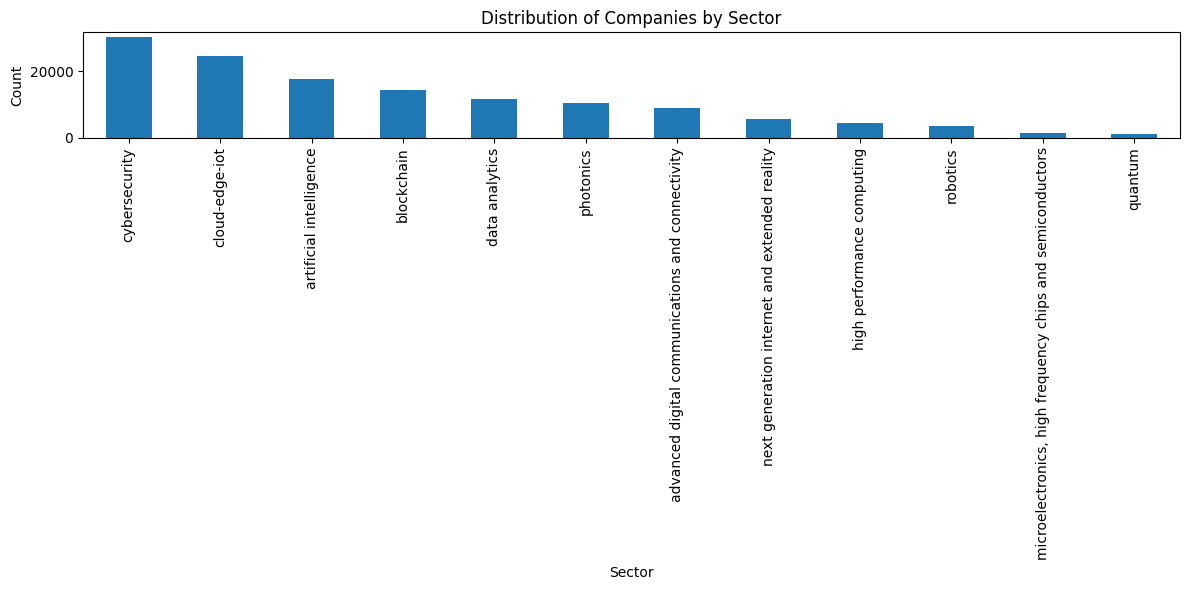

In [26]:
import matplotlib.pyplot as plt

glass_AI_enriched['sector'].value_counts().plot(kind='bar', figsize=(12,6))
plt.xlabel('Sector')
plt.ylabel('Count')
plt.title('Distribution of Companies by Sector')
plt.tight_layout()
plt.show()

In [24]:
print(glass_AI_enriched['sector'].unique())


['cloud-edge-iot' 'high performance computing' 'data analytics'
 'advanced digital communications and connectivity' 'cybersecurity'
 'artificial intelligence' 'blockchain' 'quantum technologies' 'robotics'
 'photonics' 'next generation internet and extended reality'
 'blockchain, distributed ledger and digital identity technologies'
 'microelectronics, high frequency chips and semiconductors'
 'advanced and high performance computing' 'quantum']


In [ ]:
glass_AI_enriched['sector'] = glass_AI_enriched['sector'].replace({
    'advanced and high performance computing': 'high performance computing',
    'quantum technologies': 'quantum',
    'blockchain, distributed ledger and digital identity technologies': 'blockchain'
}) 

In [ ]:
df_filtered_companies_sector_group = df_unique_companies_by_sector.groupby('Sector').size()

In [ ]:

glass_AI_enriched_dedup = glass_AI_enriched.drop_duplicates(subset=['org_ID', 'sector'], keep='first').reset_index(drop=True)
print(glass_AI_enriched_dedup.shape)

(97919, 8)


In [30]:
save_path = PROCESSED_DATA_DIR / 'glass_ai_enriched.csv'
glass_AI_enriched_dedup.to_csv(save_path, index=False)